In [1]:
%pip install pandas
import pandas as pd
import numpy as np


df = pd.read_csv('Parking_Violations_-_2023_-_Present.csv')

# Display basic info
print("Dataset Overview:\n")
print(df.info())

# Check for missing values
print("\nMissing Values Per Column:\n")
print(df.isnull().sum())

# Drop rows that are missing values
df.dropna(inplace=True)


# Drop duplicate rows if any
df.drop_duplicates(inplace=True)

# # Standardizing column names (convert to lowercase and replace spaces with underscores)
# df.columns = df.columns.str.lower().str.replace(' ', '_')

# Display sample rows after cleaning
print("\nCleaned Dataset Sample:\n")
print(df.info())

# Check for missing values
print("\nMissing Values Per Column:\n")
print(df.isnull().sum())

Note: you may need to restart the kernel to use updated packages.
Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123832 entries, 0 to 123831
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   X              96717 non-null   float64
 1   Y              96717 non-null   float64
 2   ticket_number  123832 non-null  object 
 3   issued_date    123832 non-null  object 
 4   location       123517 non-null  object 
 5   description    123832 non-null  object 
 6   status         123832 non-null  object 
 7   amount         123832 non-null  float64
 8   LONG           96717 non-null   float64
 9   LAT            96717 non-null   float64
 10  ObjectId       123832 non-null  int64  
dtypes: float64(5), int64(1), object(5)
memory usage: 10.4+ MB
None

Missing Values Per Column:

X                27115
Y                27115
ticket_number        0
issued_date          0
location           315
descrip

In [2]:
from difflib import SequenceMatcher
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

# Function to check if two strings are similar
def are_strings_similar(str1, str2, threshold=0.8):
    return SequenceMatcher(None, str1.lower(), str2.lower()).ratio() > threshold

# Function to find similar locations
def find_similar_location(lat, long, location, existing_locations, coord_threshold=0.001):
    for ex_lat, ex_long, ex_loc in existing_locations:
        # Check if coordinates are within threshold
        if (abs(lat - ex_lat) <= coord_threshold and 
            abs(long - ex_long) <= coord_threshold and 
            are_strings_similar(location, ex_loc)):
            return ex_loc
    return None

# Create a list to store unique locations
unique_locations = []
location_mapping = {}

# First pass: Identify unique locations
for index, row in df.iterrows():
    lat, long = row['LAT'], row['LONG']
    location = row['location']
    
    # Check if similar location exists
    similar_loc = find_similar_location(lat, long, location, unique_locations)
    
    if similar_loc:
        location_mapping[(lat, long)] = similar_loc
    else:
        unique_locations.append((lat, long, location))
        location_mapping[(lat, long)] = location

# Create cleaned_location column
df['cleaned_location'] = df.apply(
    lambda row: location_mapping[(row['LAT'], row['LONG'])], 
    axis=1
)

# Display results
print(df[['location', 'cleaned_location', 'LAT', 'LONG']])

                location  cleaned_location        LAT       LONG
0        300 WAVERLY AVE   300 WAVERLY AVE  43.040398 -76.132407
1       700 COMSTOCK AVE  700 COMSTOCK AVE  43.038377 -76.129968
3        300 WAVERLY AVE   300 WAVERLY AVE  43.040398 -76.132407
4       700 COMSTOCK AVE  700 COMSTOCK AVE  43.038277 -76.129945
5       700 COMSTOCK AVE  700 COMSTOCK AVE  43.038277 -76.129945
...                  ...               ...        ...        ...
123826    800 IRVING AVE    800 IRVING AVE  43.038324 -76.139032
123827    800 IRVING AVE    800 IRVING AVE  43.038324 -76.139032
123828    700 IRVING AVE    700 IRVING AVE  43.039491 -76.138067
123829    800 IRVING AVE    800 IRVING AVE  43.038324 -76.139032
123830    700 IRVING AVE    700 IRVING AVE  43.039677 -76.138067

[96717 rows x 4 columns]


In [4]:
def categorize_violation(violation):
    # Time-based violations
    if any(keyword in violation for keyword in ['OVERTIME', 'AM-', 'PM-', 'AM -', 'PM -']):
        return 'Time-Based'
    
    # Seasonal parking
    elif 'ODD/EVEN PARKING' in violation:
        return 'Seasonal'
    
    # Safety violations
    elif any(keyword in violation for keyword in ['FIRE', 'OBSTRUCTING TRAFFIC']):
        return 'Safety'
    
    # Vehicle documentation
    elif any(keyword in violation for keyword in ['UNINSPECTED', 'UNREGSTRD', 'LICENSE PLATE']):
        return 'Documentation'
    
    # Location-based violations
    elif any(keyword in violation for keyword in ['NO PARKING', 'NO STOPPING', 'NO STANDING', 'NO STPNG']):
        return 'Location-Based'
    
    # Accessibility violations
    elif 'HANDICAP' in violation:
        return 'Accessibility'
    
    # Improper parking method
    elif any(keyword in violation for keyword in ['WHEELS TO CURB', 'FROM CURB', 'DOUBLE PARKING', 'ANGLE']):
        return 'Improper Parking'
    
    # Special zone violations
    elif any(keyword in violation for keyword in ['LOADING ZONE', 'BUS STOP', 'TAXI STAND']):
        return 'Special Zone'
    
    # Property violations
    elif any(keyword in violation for keyword in ['SIDEWALK', 'CRSSWLK', 'DRVWY', 'GRASS']):
        return 'Property'
    
    else:
        return 'Other'

# Create new column with violation categories
df['violation_category'] = df['description'].apply(categorize_violation)

# Display distribution of violation categories
print("\nViolation Categories Distribution:")
print(df['violation_category'].value_counts())



Violation Categories Distribution:
violation_category
Time-Based          33465
Seasonal            22918
Documentation       16597
Location-Based       9789
Other                3454
Safety               3109
Special Zone         2690
Accessibility        1885
Improper Parking     1407
Property             1403
Name: count, dtype: int64


In [5]:
# Define thresholds for categorization
red_threshold = 1000
yellow_threshold = 100

# Categorize locations
def categorize_location(count):
    if count >= red_threshold:
        return 'red'
    elif count >= yellow_threshold:
        return 'yellow'
    else:
        return 'green'

# Apply categorization
location_counts_category = df['cleaned_location'].value_counts().apply(categorize_location)

# Display categorized locations
print("\nCategorized Locations:\n", location_counts_category)


Categorized Locations:
 cleaned_location
300 SALINA ST S         red
300 WAVERLY AVE         red
300 WARREN ST S         red
100 JEFFERSON ST E      red
300 MONTGOMERY ST       red
                      ...  
944 WESTCOTT ST       green
842 WESTCOTT ST       green
217 WILSON ST         green
1633 GENESEE ST E     green
600 RIDGEWAY AVE      green
Name: count, Length: 1979, dtype: object


In [6]:
def categorize_status(status):
    status_categories = {
        'Initial': ['Issued', 'ADMINISTRATIVE REVIEW'],
        'Notice': ['Second Notice', 'Third Notice', 'Fourth Notice'],
        'Adjudication': ['Adjudicate 30 days Pay or Appeal', 'Adjudication Pending', 
                        'Adjudication Sustained', 'Adjudication Dismissed', 
                        'Adjudication Partial', 'Adjudication Default Collections'],
        'Appeal': ['Appeal Pending', 'Hearing Appeal Pending', 
                  'Appeal Approved', 'Appeal Denied'],
        'Payment': ['Paid In Full', 'Promise To Pay', 'Promise To Pay - Default'],
        'Collections': ['Collections', 'Sent to Collections', 'Paid In Collections'],
        'Special': ['In Bankruptcy', 'Written Off', 'Void Approved', 'Void Pending']
    }
    
    for category, status_list in status_categories.items():
        if status in status_list:
            return category
    return 'Other'

# Create new column with status categories
df['status_category'] = df['status'].apply(categorize_status)

# Display distribution of status categories
print("\nStatus Categories Distribution:")
print(df['status_category'].value_counts())


Status Categories Distribution:
status_category
Payment         61745
Collections     20049
Adjudication     5271
Initial          3890
Notice           2702
Special          1723
Other            1272
Appeal             65
Name: count, dtype: int64


In [7]:
%pip install folium
import folium

# Create a base map
m = folium.Map(location=[43.0481, -76.1474], zoom_start=13)

# Add categorized locations to the map
for loc, category in location_counts_category.items():
    # Get coordinates for this location from the first matching row
    loc_data = df[df['cleaned_location'] == loc].iloc[0]
    lat = loc_data['LAT']
    lon = loc_data['LONG']
    
    # Set the color based on the category
    if category == 'red':
        color = 'red'
    elif category == 'yellow':
        color = 'orange'
    else:
        color = 'grey'  
    
    # Add a marker to the map
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=loc
    ).add_to(m)

# Display the map
m


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


/var/folders/b6/8kmpl5ms6hsgvt6gg3fhkn3h0000gn/T/ipykernel_32469/1276145328.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.index, y=location_counts.values, palette="coolwarm")


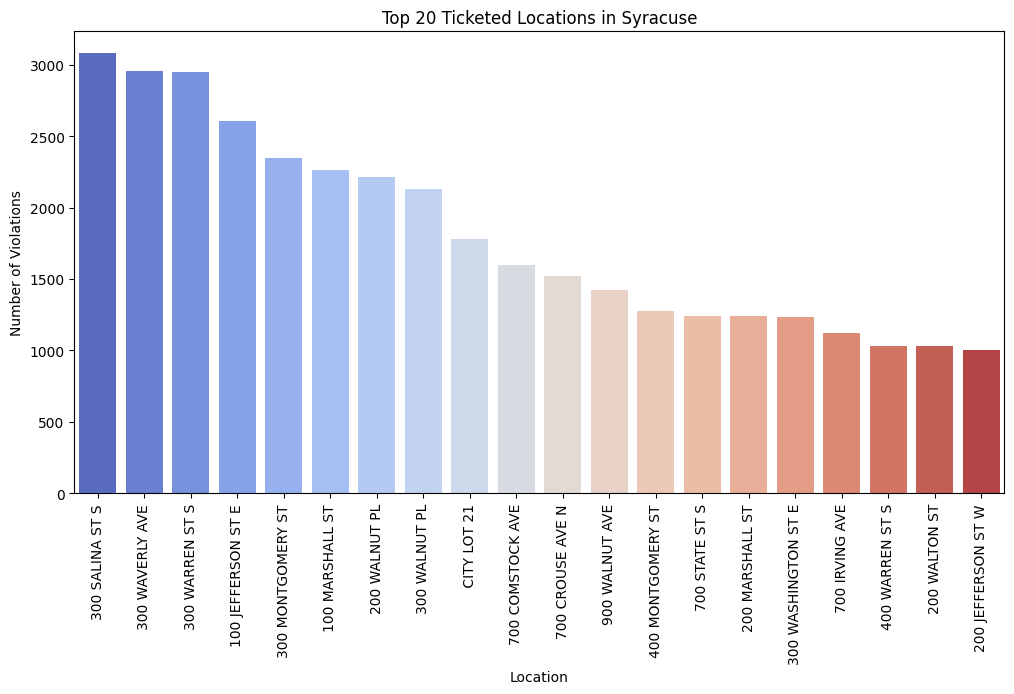

In [8]:
%pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Count violations per cleaned location
location_counts = df['cleaned_location'].value_counts().head(20)  # Top 20 locations

# Plot the data
plt.figure(figsize=(12,6))
sns.barplot(x=location_counts.index, y=location_counts.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 20 Ticketed Locations in Syracuse")
plt.xlabel("Location")
plt.ylabel("Number of Violations")
plt.show()

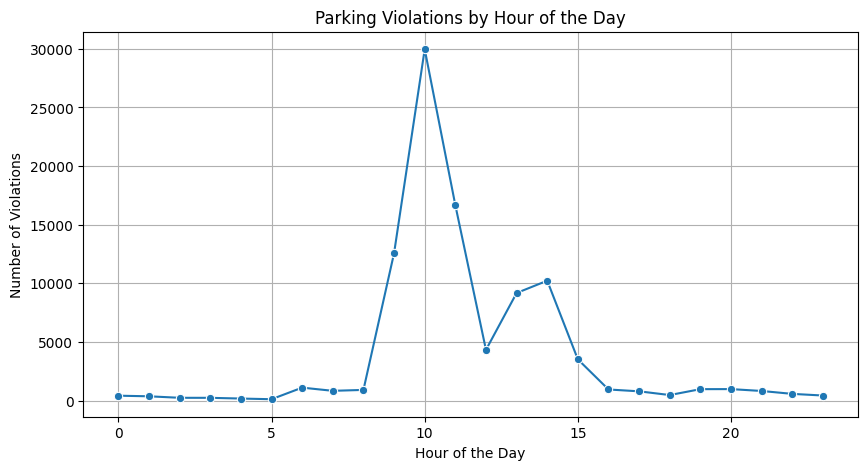

In [10]:
# Convert date column to datetime format
df['issued_date'] = pd.to_datetime(df['issued_date'], errors='coerce')

# Extract hour, day, month for analysis
df['hour'] = df['issued_date'].dt.hour
df['day_of_week'] = df['issued_date'].dt.day_name()
df['month'] = df['issued_date'].dt.month_name()

# Count violations per hour
hourly_violations = df['hour'].value_counts().sort_index()

# Plot violations by time of day
plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_violations.index, y=hourly_violations.values, marker="o")
plt.title("Parking Violations by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Violations")
plt.grid()
plt.show()

/var/folders/b6/8kmpl5ms6hsgvt6gg3fhkn3h0000gn/T/ipykernel_32469/2780894702.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="viridis")


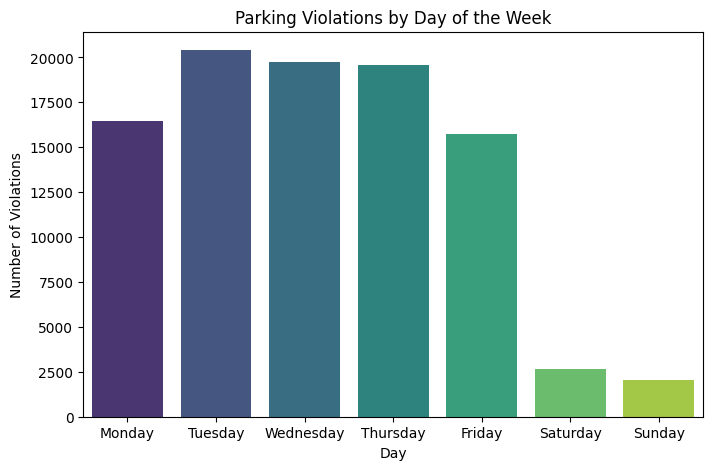

In [11]:
# Count violations per day of the week
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df['day_of_week'].value_counts().reindex(weekday_order)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="viridis")
plt.title("Parking Violations by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Number of Violations")
plt.show()

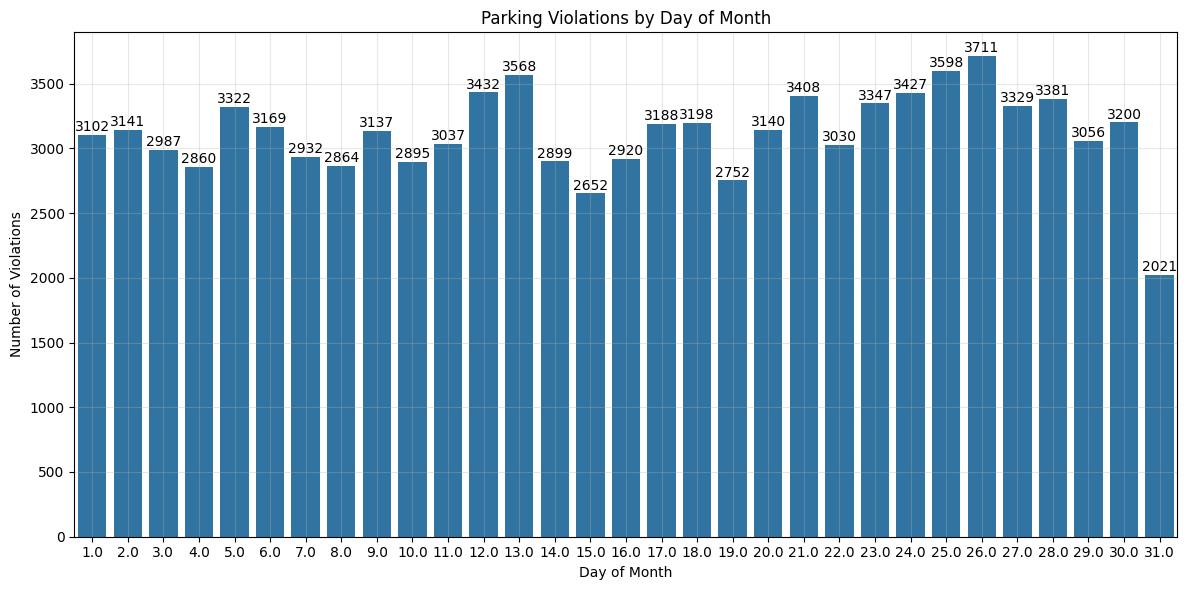


Day 26.0 has the most violations with 3711 tickets


In [12]:
# Extract day of month from issued_date
df['day_of_month'] = df['issued_date'].dt.day

# Count violations by day of month
monthly_pattern = df['day_of_month'].value_counts().sort_index()

# Create the visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_pattern.index, y=monthly_pattern.values)

# Customize the plot
plt.title('Parking Violations by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Number of Violations')
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(monthly_pattern.values):
    plt.text(i, v + 30, str(v), ha='center')

plt.tight_layout()
plt.show()

# Print the day with most violations
max_day = monthly_pattern.idxmax()
max_violations = monthly_pattern.max()
print(f"\nDay {max_day} has the most violations with {max_violations} tickets")

/var/folders/b6/8kmpl5ms6hsgvt6gg3fhkn3h0000gn/T/ipykernel_32469/1568711475.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=ax1, palette='coolwarm')
/var/folders/b6/8kmpl5ms6hsgvt6gg3fhkn3h0000gn/T/ipykernel_32469/1568711475.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seasonal_monthly.index, y=seasonal_monthly.values, ax=ax2, palette='coolwarm')


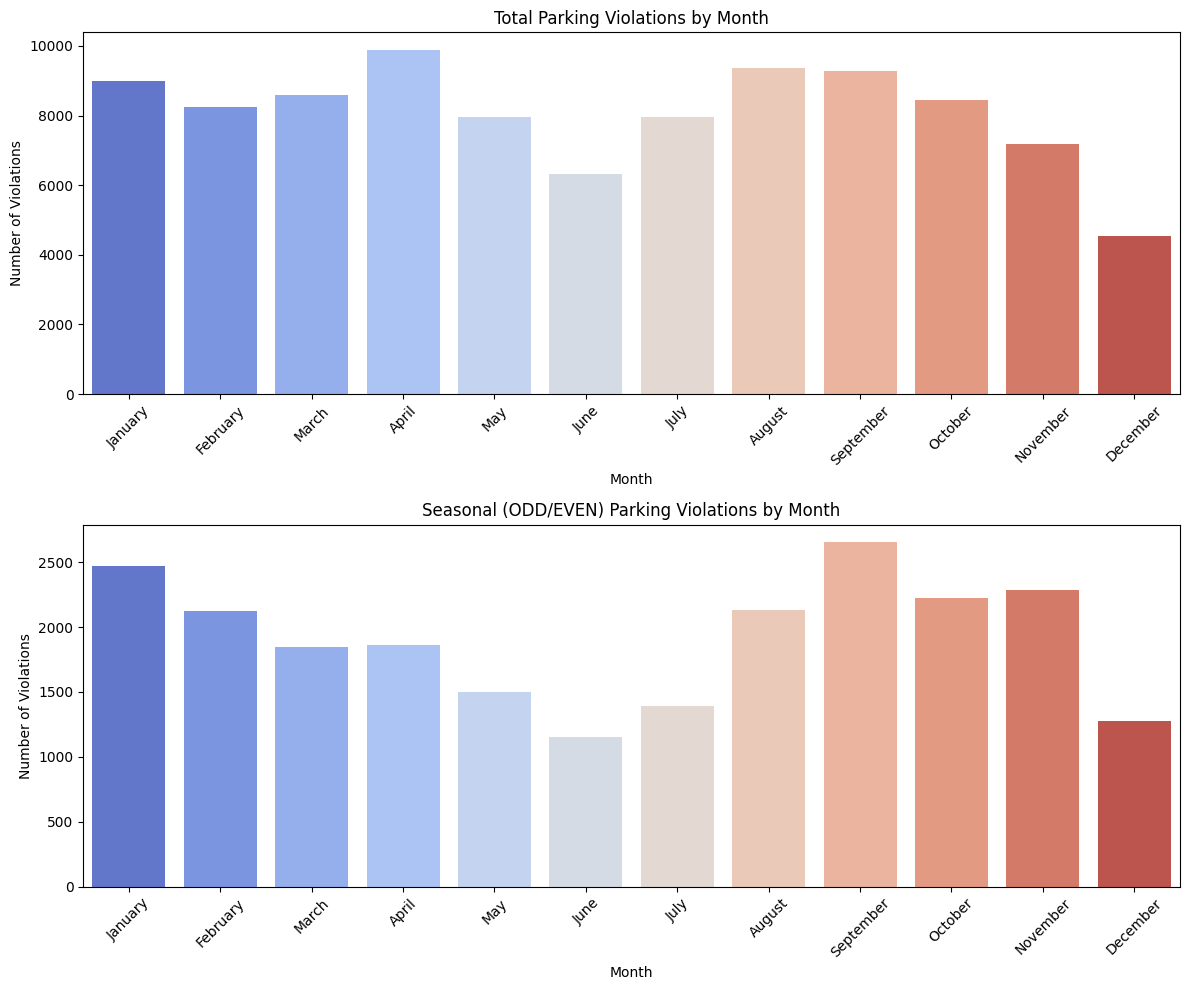


Seasonal Analysis:
Winter months (Dec-Mar) violations: 30,343
Summer months (Jun-Sep) violations: 32,907
Difference (Winter - Summer): -2,564


In [13]:
# Convert month names to numbers for proper ordering
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Count violations by month
monthly_counts = df['month'].value_counts().reindex(month_order)

# Create figure and axis for two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Total violations by month
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=ax1, palette='coolwarm')
ax1.set_title('Total Parking Violations by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Violations')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Seasonal violations (focus on ODD/EVEN parking rules)
seasonal_violations = df[df['description'].str.contains('ODD/EVEN PARKING', na=False)]
seasonal_monthly = seasonal_violations['month'].value_counts().reindex(month_order)

sns.barplot(x=seasonal_monthly.index, y=seasonal_monthly.values, ax=ax2, palette='coolwarm')
ax2.set_title('Seasonal (ODD/EVEN) Parking Violations by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Violations')
ax2.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print some statistics
print("\nSeasonal Analysis:")
winter_months = ['December', 'January', 'February', 'March']
summer_months = ['June', 'July', 'August', 'September']

winter_violations = df[df['month'].isin(winter_months)]['ticket_number'].count()
summer_violations = df[df['month'].isin(summer_months)]['ticket_number'].count()

print(f"Winter months (Dec-Mar) violations: {winter_violations:,}")
print(f"Summer months (Jun-Sep) violations: {summer_violations:,}")
print(f"Difference (Winter - Summer): {winter_violations - summer_violations:,}")

In [14]:
# Count occurrences of each violation type
violation_counts = df['description'].value_counts()

# Display top 10 most common violations
print("\nTop 10 Most Common Parking Violations:\n", violation_counts.head(10))


Top 10 Most Common Parking Violations:
 description
OVERTIME PRKNG MON-SAT 9AM-6PM CO15-383    33254
ODD/EVEN PARKING APR-OCT CO15-318 (A)2     12881
ODD/EVEN PARKING NOV-MAR CO15-318 (A)2     10037
UNINSPECTED/ ALL TIMES VTL 306-B            8430
UNREGSTRD/UNAFFIXD/ALL VTL401-1/403-1       6180
NO STOPPING ANY TIME CO15-316 (A)14         4423
NO PARKING ANY TIME CO15-316 (A)14          2816
PARKED IN LOADING ZONE/ALL CO15-329         2621
NO STPNG HERE TO CNR/ALL CO15-316(A)6       2509
NONE/ONE LICENSE PLATE/ALL VTL402-1         1987
Name: count, dtype: int64


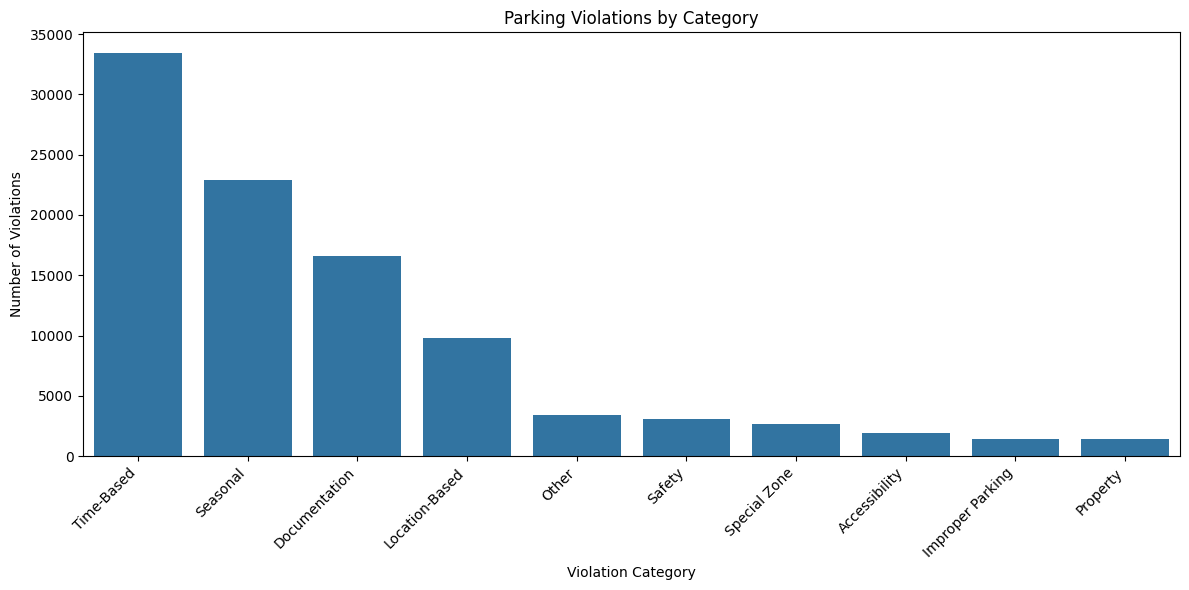

In [16]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a DataFrame with violation categories and their counts
violation_category_counts = df['violation_category'].value_counts().reset_index()
violation_category_counts.columns = ['Category', 'Count']

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=violation_category_counts, x='Category', y='Count')

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.title('Parking Violations by Category')
plt.xlabel('Violation Category')
plt.ylabel('Number of Violations')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()


/var/folders/b6/8kmpl5ms6hsgvt6gg3fhkn3h0000gn/T/ipykernel_32469/1876991483.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.groupby('violation_category')['amount'].sum().reset_index(),


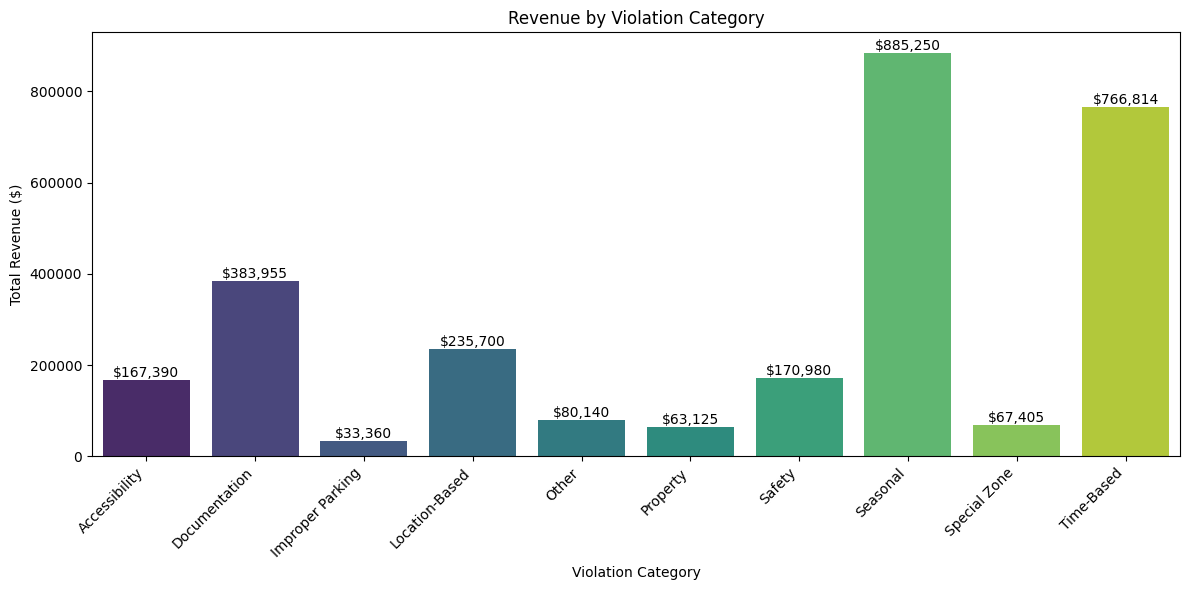


Average Fine by Category:
Accessibility  : $88.80
Safety         : $55.00
Property       : $44.99
Seasonal       : $38.63
Special Zone   : $25.06
Location-Based : $24.08
Improper Parking: $23.71
Other          : $23.20
Documentation  : $23.13
Time-Based     : $22.91


In [17]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Create bar plot
sns.barplot(data=df.groupby('violation_category')['amount'].sum().reset_index(), 
            x='violation_category', 
            y='amount',
            palette='viridis')

# Customize the plot
plt.title('Revenue by Violation Category')
plt.xlabel('Violation Category')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
category_sums = df.groupby('violation_category')['amount'].sum()
for i, v in enumerate(category_sums):
    plt.text(i, v, f'${v:,.0f}', ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Calculate and display average fines per category
print("\nAverage Fine by Category:")
category_stats = df.groupby('violation_category')['amount'].agg(['mean']).sort_values('mean', ascending=False)
for idx, row in category_stats.iterrows():
    print(f"{idx:<15}: ${row['mean']:.2f}")

In [18]:
# Find the unique fine amounts and their frequencies
fine_amounts = df['amount'].value_counts().sort_index()
print("Unique Fine Amounts:")
for amount, count in fine_amounts.items():
    print(f"${amount:.2f}: {count:,} tickets")

# Find tickets with highest fine amount
highest_fine = df['amount'].max()
highest_fine_tickets = df[df['amount'] == highest_fine]
print(f"\nHighest Fine Amount: ${highest_fine:.2f}")
print("\nTickets with Highest Fine:")
print(highest_fine_tickets[['description', 'amount', 'cleaned_location', 'violation_category']].head())

# Find tickets with lowest non-zero fine amount
lowest_fine = df[df['amount'] > 0]['amount'].min()
lowest_fine_tickets = df[df['amount'] == lowest_fine]
print(f"\nLowest Non-Zero Fine Amount: ${lowest_fine:.2f}")
print("\nTickets with Lowest Fine:")
print(lowest_fine_tickets[['description', 'amount', 'cleaned_location', 'violation_category']].head())

# Calculate statistics
print("\nFine Amount Statistics:")
print(f"Average Fine: ${df['amount'].mean():.2f}")
print(f"Median Fine: ${df['amount'].median():.2f}")
print(f"Most Common Fine: ${df['amount'].mode()[0]:.2f}")

Unique Fine Amounts:
$-25.00: 1 tickets
$-5.00: 1 tickets
$0.00: 5,820 tickets
$5.00: 17 tickets
$10.00: 783 tickets
$15.00: 40 tickets
$20.00: 7 tickets
$24.50: 1 tickets
$25.00: 74,950 tickets
$30.00: 3 tickets
$35.00: 1 tickets
$40.00: 13 tickets
$50.00: 24 tickets
$60.00: 13,391 tickets
$75.00: 2 tickets
$85.00: 10 tickets
$100.00: 1,648 tickets
$120.00: 2 tickets
$125.00: 3 tickets

Highest Fine Amount: $125.00

Tickets with Highest Fine:
                                   description  amount  \
51141  OVERTIME PRKNG MON-SAT 9AM-6PM CO15-383   125.0   
69423  OVERTIME PRKNG MON-SAT 9AM-6PM CO15-383   125.0   
69427         UNINSPECTED/ ALL TIMES VTL 306-B   125.0   

                cleaned_location violation_category  
51141             900 WALNUT AVE         Time-Based  
69423                SALINA ST S         Time-Based  
69427   DESTINY USA NORTH GARAGE      Documentation  

Lowest Non-Zero Fine Amount: $5.00

Tickets with Lowest Fine:
                                 descrip


Revenue Statistics:
Total Revenue: $2,853,934.50
Average Monthly Revenue: $101,926.23
Highest Revenue Month: 2024-02 ($164,765.00)


/var/folders/b6/8kmpl5ms6hsgvt6gg3fhkn3h0000gn/T/ipykernel_32469/969514294.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['issued_date'].dt.to_period('M')


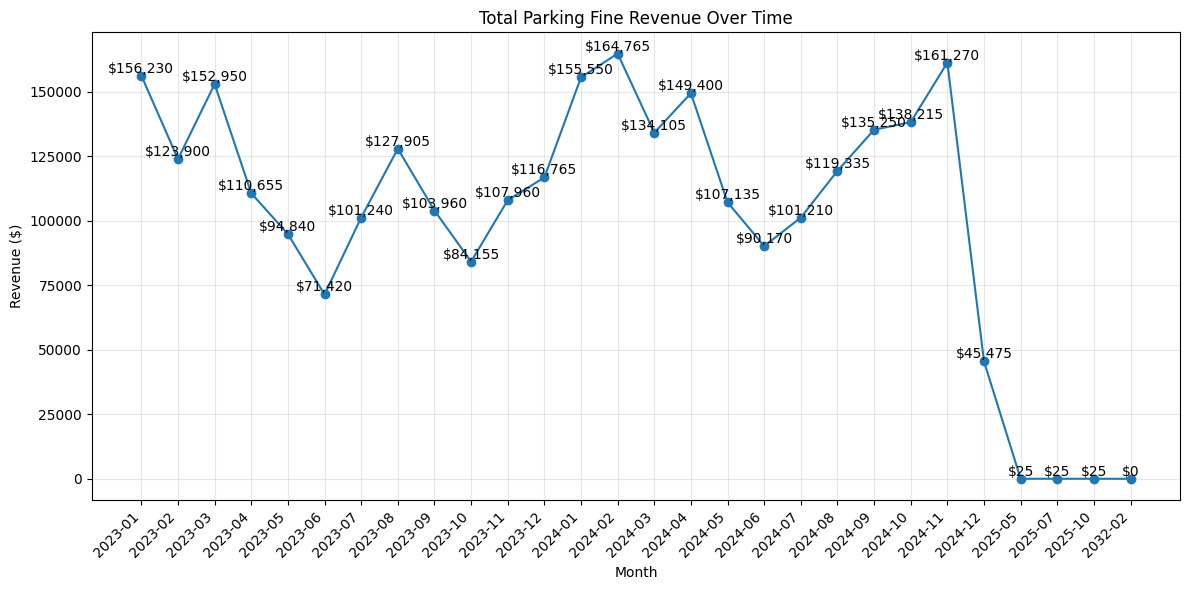

In [19]:
# Group revenue by month and year
df['year_month'] = df['issued_date'].dt.to_period('M')
monthly_revenue = df.groupby('year_month')['amount'].sum().reset_index()
monthly_revenue['year_month'] = monthly_revenue['year_month'].astype(str)

# Create the visualization
plt.figure(figsize=(12, 6))

# Plot monthly revenue
plt.plot(monthly_revenue['year_month'], monthly_revenue['amount'], marker='o')

# Customize the plot
plt.title('Total Parking Fine Revenue Over Time')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of points
for i, v in enumerate(monthly_revenue['amount']):
    plt.text(i, v, f'${v:,.0f}', ha='center', va='bottom')

# Calculate and print some statistics
total_revenue = monthly_revenue['amount'].sum()
average_monthly_revenue = monthly_revenue['amount'].mean()
max_revenue_month = monthly_revenue.loc[monthly_revenue['amount'].idxmax(), 'year_month']
max_revenue = monthly_revenue['amount'].max()

print(f"\nRevenue Statistics:")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Average Monthly Revenue: ${average_monthly_revenue:,.2f}")
print(f"Highest Revenue Month: {max_revenue_month} (${max_revenue:,.2f})")

plt.tight_layout()
plt.show()

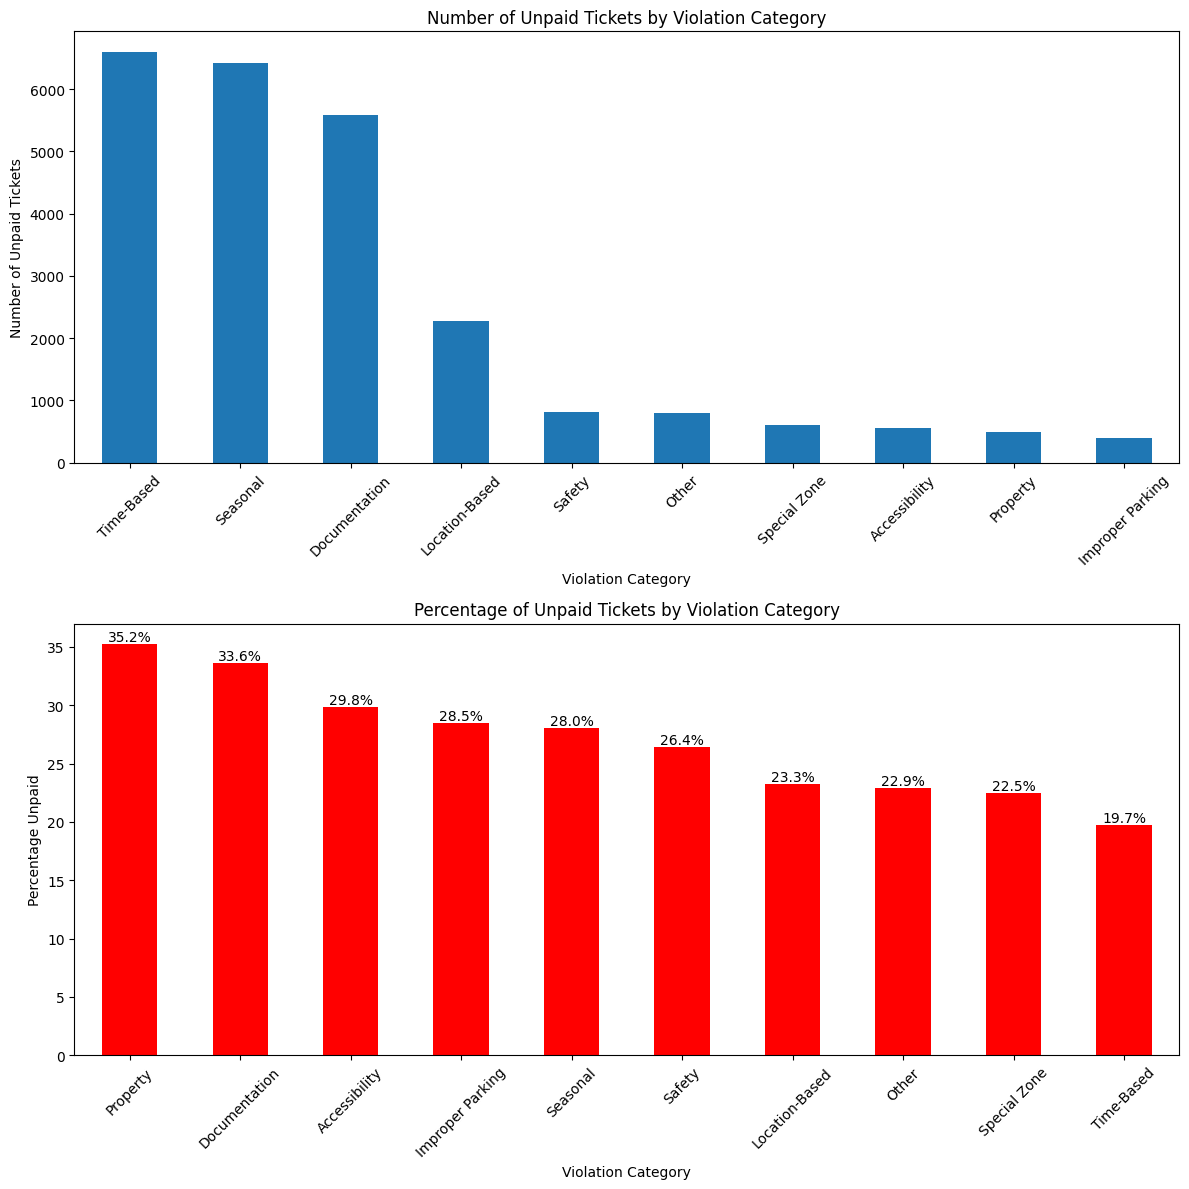


Unpaid Ticket Analysis:
Total Tickets: 96,717
Unpaid Tickets: 24,550
Percentage Unpaid: 25.4%

Categories with Highest Unpaid Rates:
Property: 35.2%
Documentation: 33.6%
Accessibility: 29.8%
Improper Parking: 28.5%
Seasonal: 28.0%


In [21]:
# Define unpaid statuses (excluding Paid in Full, Void, and Dismissed)
unpaid_statuses = ['Collections', 'Issued', 'Second Notice', 'Third Notice', 'Fourth Notice', 
                   'Sent to Collections', 'Adjudicate 30 days Pay or Appeal']

# Calculate unpaid tickets
unpaid_tickets = df[df['status'].isin(unpaid_statuses)]
total_tickets = len(df)
unpaid_count = len(unpaid_tickets)

# Calculate unpaid tickets by violation category
unpaid_by_category = unpaid_tickets['violation_category'].value_counts()
total_by_category = df['violation_category'].value_counts()

# Calculate percentage of unpaid tickets for each category
unpaid_percentage = (unpaid_by_category / total_by_category * 100).sort_values(ascending=False)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Number of unpaid tickets by category
unpaid_by_category.plot(kind='bar', ax=ax1)
ax1.set_title('Number of Unpaid Tickets by Violation Category')
ax1.set_xlabel('Violation Category')
ax1.set_ylabel('Number of Unpaid Tickets')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Percentage of unpaid tickets by category
unpaid_percentage.plot(kind='bar', ax=ax2, color='red')
ax2.set_title('Percentage of Unpaid Tickets by Violation Category')
ax2.set_xlabel('Violation Category')
ax2.set_ylabel('Percentage Unpaid')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on top of bars
for i, v in enumerate(unpaid_percentage):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nUnpaid Ticket Analysis:")
print(f"Total Tickets: {total_tickets:,}")
print(f"Unpaid Tickets: {unpaid_count:,}")
print(f"Percentage Unpaid: {(unpaid_count/total_tickets*100):.1f}%")

print("\nCategories with Highest Unpaid Rates:")
for category, percentage in unpaid_percentage.head().items():
    print(f"{category}: {percentage:.1f}%")

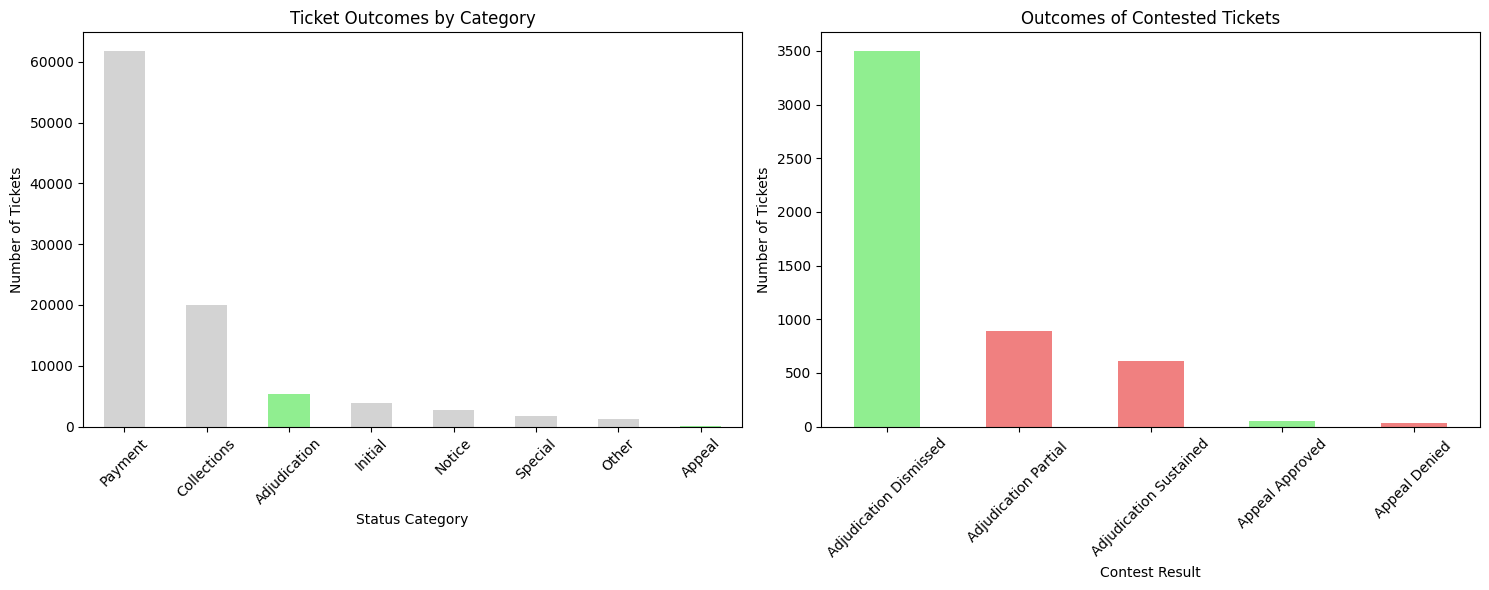


Ticket Dismissal Analysis:
Overall dismissal rate: 5.44%

Detailed contest outcomes:
Adjudication Dismissed: 68.70%
Adjudication Partial : 17.52%
Adjudication Sustained: 12.06%
Appeal Approved: 1.00%
Appeal Denied : 0.73%


In [25]:
# Calculate ticket outcomes
outcome_counts = df['status'].value_counts()
outcome_percentages = (outcome_counts / len(df) * 100).round(2)

# Group statuses into meaningful categories for analysis
dismissal_statuses = ['Adjudication Dismissed', 'Void Approved', 'Appeal Approved']
contested_statuses = ['Adjudication Dismissed', 'Adjudication Sustained', 'Appeal Approved', 
                     'Appeal Denied ', 'Adjudication Partial ']

# Calculate dismissal statistics
dismissed_tickets = df[df['status'].isin(dismissal_statuses)]
contested_tickets = df[df['status'].isin(contested_statuses)]

dismissal_rate = len(dismissed_tickets) / len(df) * 100
contest_success_rate = len(dismissed_tickets) / len(contested_tickets) * 100 if len(contested_tickets) > 0 else 0

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Overall Ticket Outcomes
status_categories = df['status_category'].value_counts()
status_percentages = (status_categories / len(df) * 100).round(2)

colors = ['lightgreen' if cat in ['Adjudication', 'Appeal'] else 'lightgray' for cat in status_categories.index]
status_categories.plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Ticket Outcomes by Category')
ax1.set_xlabel('Status Category')
ax1.set_ylabel('Number of Tickets')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Contest Success Rate
contest_outcomes = df[df['status'].isin(contested_statuses)]['status'].value_counts()
contest_percentages = (contest_outcomes / len(contested_tickets) * 100).round(2)
colors = ['lightgreen' if 'Dismissed' in status or 'Approved' in status else 'lightcoral' for status in contest_outcomes.index]
contest_outcomes.plot(kind='bar', ax=ax2, color=colors)
ax2.set_title('Outcomes of Contested Tickets')
ax2.set_xlabel('Contest Result')
ax2.set_ylabel('Number of Tickets')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nTicket Dismissal Analysis:")
print(f"Overall dismissal rate: {dismissal_rate:.2f}%")
# print(f"Success rate when contested: {contest_success_rate:.2f}%")
print("\nDetailed contest outcomes:")
for status, percentage in contest_percentages.items():
    print(f"{status}: {percentage:.2f}%")

In [24]:
import folium
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points on Earth"""
    R = 6371  # Earth's radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    
    return distance

def find_nearby_parking_zones(input_lat, input_long, radius_km=1):
    """Find and display parking zones near the input location"""
    
    # Find the nearest location in our dataset if input location isn't in dataset
    nearest_loc = None
    min_distance = float('inf')
    
    for _, row in df.iterrows():
        dist = haversine_distance(input_lat, input_long, row['LAT'], row['LONG'])
        if dist < min_distance:
            min_distance = dist
            nearest_loc = (row['LAT'], row['LONG'])
    
    # Use either input location or nearest location as center
    center_lat = input_lat if min_distance > radius_km else nearest_loc[0]
    center_long = input_long if min_distance > radius_km else nearest_loc[1]
    
    # Create base map
    m = folium.Map(location=[center_lat, center_long], zoom_start=15)
    
    # Add marker for input/search location
    folium.Marker(
        [input_lat, input_long],
        popup='Search Location',
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)
    
    # Add nearby parking zones
    location_counts = df['cleaned_location'].value_counts()
    
    for idx, row in df.drop_duplicates(subset=['cleaned_location']).iterrows():
        loc_lat, loc_long = row['LAT'], row['LONG']
        
        # Check if location is within radius
        if haversine_distance(center_lat, center_long, loc_lat, loc_long) <= radius_km:
            count = location_counts[row['cleaned_location']]
            
            # Determine zone color based on ticket count
            if count >= 1000:  # red zone
                color = 'red'
                risk = 'High Risk'
            elif count >= 100:  # yellow zone
                color = 'orange'
                risk = 'Medium Risk'
            else:  # green zone
                color = 'grey'
                risk = 'Low Risk'
            
            # Add circle marker
            folium.CircleMarker(
                location=[loc_lat, loc_long],
                radius=8,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"Location: {row['cleaned_location']}<br>Tickets: {count}<br>Risk Level: {risk}"
            ).add_to(m)
    
    return m

# Example usage (you can replace with any lat/long):
map_display = find_nearby_parking_zones(43.045388, -76.132693)
map_display